# Intro to My Custom LRP Algorithm
### by Jñani Crawford
#### Stanford University, CS231n, Spring '19

The process for generating relevance maps for a given model and batch of images is as follows (This code is mostly pasted from a larger notebook of mine but is here for demonstration, so I won't go through all the prerequisite imports, etc):

1. <code>run_all_layers()</code> generates the activations of every layer in the model with respect to an input <code>batch</code>
2. <code>prepareDictionaries</code> turns the outputs and the model weights (given as a list with the same length as <code>model.layers</code> from lists into dictionaries, keyed by the layer name (for easier unordered access)

In [ ]:
#calculate EVERY LAYERS outputs
def run_all_layers(batch, model):

    outputs_ph = [layer.output for layer in model.layers[1:]]          # all layer outputs
    inputs_ph = [layer.input for layer in model.layers[1:]] 
    
    # Testing
    m = keras.models.Model(inputs=model2.input, outputs=outputs_ph)
    return [batch]+m.predict(batch)  

#put the dicts in the global namespace
weights_dict = {}
outputs_dict = {}
inputs_dict = {}
layers_dict = {}
relevances_dict = {}

#turn values from arrays into dictionaries
def prepareDictionaries(outputs, weights):
    weights_dict.clear()
    outputs_dict.clear()
    inputs_dict.clear()
    layers_dict.clear()
    relevances_dict.clear()
    for i in range(len(outputs)):
        name = model2.layers[i].name
        outputs_dict[name] = outputs[i]
        weights_dict[name] = weights[i]
        if (type(model2.layers[i].input) != list):
            inputs_dict[name] = model2.layers[i].input.name.split("/")[0]
            if (":" in inputs_dict[name] or "branch" in inputs_dict[name] or "_pad" in inputs_dict[name] or "bn_" in inputs_dict[name] or "conv1_1" in inputs_dict[name]):
                inputs_dict[name] = inputs_dict[name][0:-2]
        else:
            input_names = []
            for inp in model2.layers[i].input:
                n = inp.name.split("/")[0]
                if ("branch" in n):
                    n = n[0:-2]
                input_names += [n]

            inputs_dict[name] = input_names

        layers_dict[name] = model2.layers[i]
        relevances_dict[name] = np.zeros_like(outputs[i])
    return weights_dict,outputs_dict,inputs_dict,layers_dict,relevances_dict

3. Next, methods are defined to specify the LRP rules. These are each described in the paper.

In [ ]:
#top dense layer
def LRPDense(inputs,weights,previous_relevances):
    relevances = np.zeros_like(inputs)
    #zijs
    preactivations = np.diag(inputs[0,:]).dot(weights[0])
    
    #split into positive and negative components
    preactivations_p = np.maximum(0,preactivations)
    preactivations_n = np.minimum(0,preactivations)
    preactivation_sums_p = np.sum(preactivations_p, axis=0) + np.maximum(0,weights[1])
    preactivation_sums_n = np.sum(preactivations_n, axis=0) + np.minimum(0,weights[1])
    
    preactivation_fraction_p = 0.5 * preactivations_p / preactivation_sums_p 
    preactivation_fraction_n = 0.5 * preactivations_n / preactivation_sums_n
    
    preactivation_fraction_p = np.where(np.isfinite(preactivation_fraction_p), preactivation_fraction_p, 0)
    preactivation_fraction_n = -np.where(np.isfinite(preactivation_fraction_n), preactivation_fraction_n, 0)
    
    relevance_messages = (preactivation_fraction_n * previous_relevances) + (preactivation_fraction_p * previous_relevances)
    relevances = relevance_messages.sum(axis=1)
    return relevances

#max-pooling layer
def LRPMaxPool2D(inputs,previous_relevances,padding,stride,poolsize):    
    if 'valid' in padding:
        padding = 0
    else:
        if inputs.shape[1]%stride[0] == 0:
            padding=np.maximum(kernels[0].shape[0] - stride[0],0)
        else:
            padding=np.maximum(kernels[0].shape[0] - (inputs.shape[1]%stride[0]),0)
    
    relevance = np.zeros_like(inputs)
    
    #relprop for each channel to its RF
    for i in range(previous_relevances.shape[3]):
        for a in range(previous_relevances.shape[1]):
            for b in range(previous_relevances.shape[2]):
                tpixels = np.sum(np.ones(poolsize))
                c = (padding)+(stride[0])*(a)
                d = (padding)+(stride[1])*(b)
                
                relevance[...,c:c+poolsize[0],d:d+poolsize[1],i] += previous_relevances[0,a,b,i]/tpixels

    return relevance

#global average-pooling layer
def LRPGlobAvgPool2D(inputs,previous_relevances):
    relevances = np.zeros_like(inputs)
    print(np.isfinite(previous_relevances).all())
    
    for m in range(inputs.shape[-1]) :
        relevances[:,:,:,m] = previous_relevances[...,m]/np.sum(np.ones_like(inputs[:,:,:,m]))
        relevances[:,:,:,m] = np.where(np.isfinite(relevances[:,:,:,m]), relevances[:,:,:,m], 0)

    return relevances

#simple activation layer
def LRPActivation(previous_relevances):
    return previous_relevances

#adding layer, need to branch the recursion here!
def LRPAdd(activations,inputs,weights,previous_relevances):
    #find the inputs being added
    print("    branching relevance to",inputs[0],"and",inputs[1])
    
    sums = np.abs(outputs_dict[inputs[0]]) + np.abs(outputs_dict[inputs[1]])
    
    relevance_per_branch = []
    for input_name in inputs:
        relevance_per_branch.append(previous_relevances*(np.abs(outputs_dict[input_name])/sums))
    
    return relevance_per_branch

#batchnorm layer
def LRPBatchNormV1(inputs,weights,previous_relevances):
    return previous_relevances

def LRPGenConv(inputs, kernels, previous_relevances, activations, stride, padding):
    
    print("input:",inputs.shape)
    for kern in kernels:
        print('    kernel:',kern.shape)
    print(previous_relevances.shape)
    
    if 'valid' in padding:
        padding = 0
    else:
        if inputs.shape[1]%stride[0] == 0:
            padding=np.maximum(kernels[0].shape[0] - stride[0],0)
        else:
            padding=np.maximum(kernels[0].shape[0] - (inputs.shape[1]%stride[0]),0)
    
    relevance = np.zeros((inputs.shape[0],inputs.shape[1]+(2*padding),inputs.shape[2]+(2*padding),inputs.shape[3]))
    inp_pad = np.zeros((inputs.shape[0],inputs.shape[1]+(2*padding),inputs.shape[2]+(2*padding),inputs.shape[3]))
    
    if padding>0:
        inp_pad[0,padding:-padding,padding:-padding,:] = inputs
    else:
        inp_pad=inputs
    
    #relprop for each kernel to its RF
    for i in range(previous_relevances.shape[3]):
        for a in range(previous_relevances.shape[1]):
            for b in range(previous_relevances.shape[2]):
                trel = previous_relevances[0,a,b,i]
                c = (padding)+(stride[0])*(a)
                d = (padding)+(stride[1])*(b)
                rf = inp_pad[...,c:c+kernels[0].shape[0],d:d+kernels[0].shape[1],:]
                
                preactivations = rf * kernels[0][:,:,:,i]
                preactivations_p = np.minimum(0,preactivations)
                preactivations_n = np.maximum(0,preactivations)
                
                preactivation_sum_p = np.sum(preactivations_p) + np.minimum(0,kernels[1])
                preactivation_sum_n = np.sum(preactivations_n) + np.maximum(0,kernels[1])
                
                rel_fractions_p = 0.5 * preactivations_p / preactivation_sum_p
                rel_fractions_n = -0.5 * preactivations_n / preactivation_sum_n
                
                rel_fractions_p = np.where(np.isfinite(rel_fractions_p), rel_fractions_p, 0)
                rel_fractions_n = np.where(np.isfinite(rel_fractions_n), rel_fractions_n, 0)
                
                relevance[...,c:c+kernels[0].shape[0],d:d+kernels[0].shape[1],:] += (trel * rel_fractions_p) + (trel * rel_fractions_n)
                
                #if this is a downsampling conv, interpolate
                if (stride[0]==2 and kernels[0].shape[0]==1): 
                    for x in range(2):
                        for y in range(2):
                            if (x,y)==(0,0):
                                continue
                            relevance[...,c+x,d+y,:]=relevance[...,c,d,:]
                        
                        
    print(relevance.shape)
    if padding>0:
        return relevance[...,padding:-padding,padding:-padding,:]
    else:
        return relevance
    
def LRPPadding(inputs, previous_relevances, padding):
    top=padding[0][0]
    bottom=padding[0][1]
    left=padding[1][0]
    right=padding[1][1]
    
    return previous_relevances[:,top:-bottom,left:-right,:]

4. <code>LRP</code> recusrively applies these rules based on the given layer name and trhe given amount of relevance to propagate from the given layer.

In [ ]:
#Recursive LRP calculation starting at layer "name" and propagating the given "rel", storing in "relevances_dict"
@supress_stdout
def LRP(name, rel, ceaseOnActivation=False, ceaseTarget=None, ceaseRel=None):
    print('Propagating relevance from \033[1m',name, "\033[0mto\033[1m", inputs_dict[name],"\033[0m")
    if (ceaseOnActivation and "activation" in name):
        print("    Reached activation. Ending this branch and merging.")
        return LRP(ceaseTarget,ceaseRel,False,None,None)
    
    #Die if relevance decays to or starts at 0
    if (rel==0).all():
        print('    Empty.')
        return rel
    
    #Apply LRP rule based on name
    if ("dense" in name):
        print('    Detected FC layer...')
        rel = LRPDense(outputs_dict[inputs_dict[name]],weights_dict[name],rel)
        relevances_dict[inputs_dict[name]] += rel
        
    elif ("max_pool" in name):
        print("    Detected max_pool layer...")
        rel = LRPMaxPool2D(outputs_dict[inputs_dict[name]],rel,layers_dict[name].get_config()["padding"], layers_dict[name].get_config()["strides"], layers_dict[name].get_config()["pool_size"])
        relevances_dict[inputs_dict[name]] += rel
        
    elif ("global_average_pooling2d" in name):
        print("    Detected globalAVGpool layer...")
        rel = LRPGlobAvgPool2D(outputs_dict[inputs_dict[name]],rel)
        relevances_dict[inputs_dict[name]] += rel
        
    elif ("activation" in name):
        print("    Detected activation layer... (and picking up any residue)")
        rel = LRPActivation(relevances_dict[name])
        relevances_dict[inputs_dict[name]] += rel
        
    elif ("add" in name):
        print("    Detected add layer...")
        rel = LRPAdd(outputs_dict[name],inputs_dict[name],weights_dict[name],rel)
        
        for i in range(len(inputs_dict[name])):
            relevances_dict[inputs_dict[name][i]] += rel[i]
    
    elif ("bn" in name):
        print("    Detected BatchNorm layer...")
        relevances_dict[inputs_dict[name]] += LRPBatchNormV1(outputs_dict[inputs_dict[name]],weights_dict[name],rel)
    
    elif ("res" in name or name=="conv1"):
        print("    Detected conv layer...")
        rel = LRPGenConv(outputs_dict[inputs_dict[name]],weights_dict[name],rel, outputs_dict[name], layers_dict[name].get_config()["strides"], layers_dict[name].get_config()["padding"])
        relevances_dict[inputs_dict[name]] += rel
    
    elif ("_pad" in name):
        print("    Detected padding layer...")
        rel = LRPPadding(inputs_dict[name],rel,layers_dict[name].get_config()["padding"])
        relevances_dict[inputs_dict[name]] += rel
        
    elif ("input" in name):
        print("--reached input layer!")
        return
    
    else:
        print("!no LRP method known for",name,"!")
        return(rel)
    
    #Call this method for the input layer(s)
    if (type(inputs_dict[name]) != list):
        print('    Done. Total relevance sent:',np.sum(np.abs(rel)))
        print()
        return LRP(inputs_dict[name], rel, ceaseOnActivation, ceaseTarget, ceaseRel)
    else:
        print('    Done. Total relevance sent:',np.sum(np.abs(rel[0]))+np.sum(np.abs(rel[1])))
        print()
        return LRP(inputs_dict[name][0], rel[0], True, inputs_dict[name][1], rel[1])

It all begins with a call to <code>LRP</code>. That's it!

In [ ]:
#prepares values needed for lrp, then runs
def relevanceMap(b):
    relevance_maps = []
    for i in range(len(b)):
        print("Analysing image",i+1,"of",len(b),"...")
        
        #Step 1 - run_all_layers
        outputs = run_all_layers(b[i:i+1], model2)
        
        #Step 2 - prepareDictionaries
        weights = [layer.get_weights() for layer in model2.layers]
        weights_dict,outputs_dict,inputs_dict,layers_dict,relevances_dict = prepareDictionaries(outputs, weights) 

        #Step 3 - Prepare arguments for first LRP()
        output_name = model2.layers[-1].name
        first_rel = np.where(outputs[-1]==outputs[-1].max(), 1, 0)
        relevances_dict[output_name] = first_rel

        #Step 4- Run recursive LRP! (can't handle >1 images per batch yet :c)
        start = time.time()
        LRP(output_name, first_rel)
        end = time.time()
        
        print("ETA:",str(time.ctime(int(time.time()+((len(b)-i-1)*(end-start))))))

        relevance_maps.append(relevances_dict["input_2"])

    return relevance_maps

#run it! (ofc "batch" is undefined here)
relevances = relevanceMap(batch)

Here are some of the maps generated by this code:
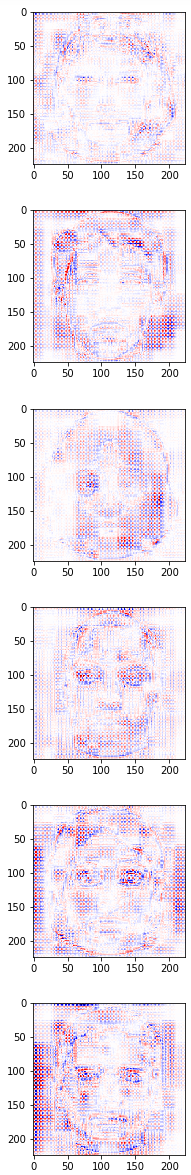